# Unsupervised Learning

Install/update seaborn by uncommenting the following cell (make sure to restart the kernel after installation is complete):

In [1]:
#!conda install seaborn

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# the following line gets the bucket name attached to our cluster
bucket = spark._jsc.hadoopConfiguration().get("fs.gs.system.bucket")

# specifying the path to our bucket where the data is located (no need to edit this path anymore)
data = "gs://" + bucket + "/notebooks/jupyter/data/"
print(data)

gs://is843/notebooks/jupyter/data/


In [4]:
df = spark.read.format("csv")\
  .option("header", "true")\
  .option("inferSchema", "true")\
  .load(data + "iris.csv")\
  .coalesce(5)

df = df.drop('_c0')
df.cache()
df.show(1)
df.printSchema()
print("This datasets consists of {} rows.".format(df.count()))

+------------+-----------+------------+-----------+-------+
|sepal_length|sepal_width|petal_length|petal_width|species|
+------------+-----------+------------+-----------+-------+
|         5.1|        3.5|         1.4|        0.2| setosa|
+------------+-----------+------------+-----------+-------+
only showing top 1 row

root
 |-- sepal_length: double (nullable = true)
 |-- sepal_width: double (nullable = true)
 |-- petal_length: double (nullable = true)
 |-- petal_width: double (nullable = true)
 |-- species: string (nullable = true)

This datasets consists of 150 rows.


In [5]:
sample_df = df.sample(fraction=0.6, seed=843)

In [6]:
sample_df = sample_df.toPandas()

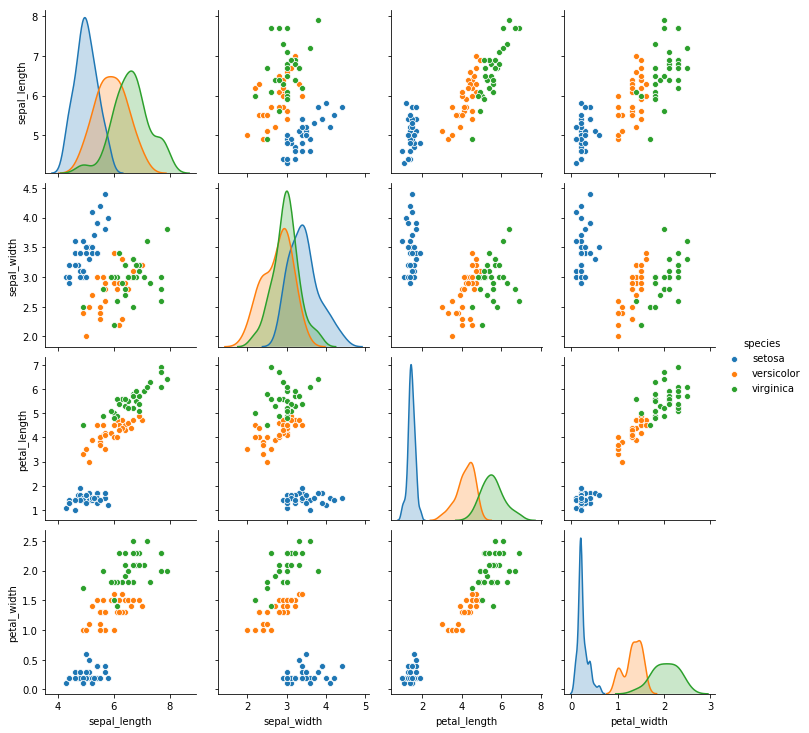

In [7]:
sns.pairplot(sample_df, hue='species');

## Principal Component Analysis - PCA

### Unsupervised learning example: Iris dimensionality reduction

As an example of an unsupervised learning problem, let's take a look at reducing the dimensionality of the Iris data so it is more easily visualizable. Recall that the Iris data is four dimensional: there are four features recorded for each sample. We will reduce it to 2, but first we need to transform the data into features. Since this is unsupervised learning we won't need a label:

In [8]:
from pyspark.ml.feature import RFormula

supervised = RFormula(formula="species ~ .")

In [9]:
fittedRF = supervised.fit(df)  # fit the transformer

In [10]:
preparedDF = fittedRF.transform(df)  # transform

In [11]:
preparedDF = preparedDF.drop("label")  # we don't really need a label
preparedDF.show(3)

+------------+-----------+------------+-----------+-------+-----------------+
|sepal_length|sepal_width|petal_length|petal_width|species|         features|
+------------+-----------+------------+-----------+-------+-----------------+
|         5.1|        3.5|         1.4|        0.2| setosa|[5.1,3.5,1.4,0.2]|
|         4.9|        3.0|         1.4|        0.2| setosa|[4.9,3.0,1.4,0.2]|
|         4.7|        3.2|         1.3|        0.2| setosa|[4.7,3.2,1.3,0.2]|
+------------+-----------+------------+-----------+-------+-----------------+
only showing top 3 rows



In [12]:
from pyspark.ml.feature import PCA as PCAml
from pyspark.ml.linalg import Vectors

In [13]:
pca = PCAml(k=2, inputCol="features", outputCol="pca")
model = pca.fit(preparedDF)
transformed = model.transform(preparedDF)

In [14]:
transformed.show(2, False)

+------------+-----------+------------+-----------+-------+-----------------+----------------------------------------+
|sepal_length|sepal_width|petal_length|petal_width|species|features         |pca                                     |
+------------+-----------+------------+-----------+-------+-----------------+----------------------------------------+
|5.1         |3.5        |1.4         |0.2        |setosa |[5.1,3.5,1.4,0.2]|[-2.818239506639473,-5.646349823412759] |
|4.9         |3.0        |1.4         |0.2        |setosa |[4.9,3.0,1.4,0.2]|[-2.788223445314683,-5.1499513517628674]|
+------------+-----------+------------+-----------+-------+-----------------+----------------------------------------+
only showing top 2 rows



Let's visualize our data in the PC1 and PC2 axes:

In [15]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType

firstElement=udf(lambda v:float(v[0]),FloatType())
secondElement=udf(lambda v:float(v[1]),FloatType())
pcaDF = transformed.select(firstElement('pca'), secondElement('pca'), 'species').toPandas()

In [16]:
pcaDF.columns = ['pc1', 'pc2', 'species']
pcaDF.head()

,pc1,pc2,species
0,-2.818239,-5.646350,setosa
1,-2.788224,-5.149951,setosa
2,-2.613374,-5.182003,setosa
3,-2.757022,-5.008654,setosa
4,-2.773649,-5.653707,setosa


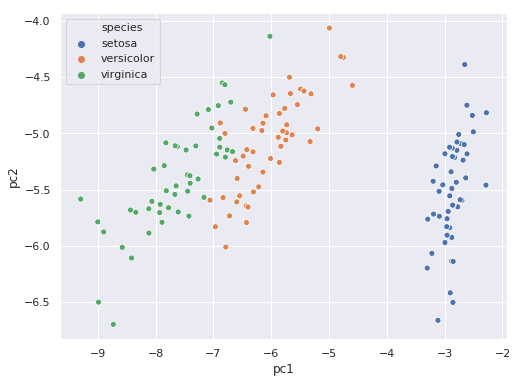

In [17]:
sns.set(rc={'figure.figsize':(8,6)})  # Figure size
sns.scatterplot(data=pcaDF, x='pc1', y='pc2', hue='species');

## k-means

𝘬-means is one of the most popular clustering algorithms. In this algorithm, a user-specified number of clusters (𝘬) are randomly assigned to different points in the dataset. The unassigned points are then “assigned” to a cluster based on their proximity (measured in Euclidean distance) to the previously assigned point. Once this assignment happens, the center of this cluster (called the centroid) is computed, and the process repeats. All points are assigned to a particular centroid, and a new centroid is computed. We repeat this process for a finite number of iterations or until convergence (i.e., when our centroid locations stop changing). This does not, however, mean that our clusters are always sensical. For instance, a given “logical” cluster of data might be split right down the middle simply because of the starting points of two distinct clusters. Thus, it is often a good idea to perform multiple runs of 𝘬-means starting with different initializations.

Below we will use the `transformed` dataframe to create the clusters. Note that only the `features` column will be used, even though we are passing the entire dataframe; i.e., the labels (`species`) won't be used in this clustering algorithm.

In [18]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Trains a k-means model.
kmeans = KMeans(k=3, seed=843)
model = kmeans.fit(transformed)

# Make predictions
predictions = model.transform(transformed)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Silhouette with squared euclidean distance = 0.7356596054332228
Cluster Centers: 
[5.9016129  2.7483871  4.39354839 1.43387097]
[5.006 3.428 1.462 0.246]
[6.85       3.07368421 5.74210526 2.07105263]


We will now visualize our clusters in the PC1 and PC2 axes and compare them with the `species` column:

In [19]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType

firstElement=udf(lambda v:float(v[0]),FloatType())
secondElement=udf(lambda v:float(v[1]),FloatType())
kMeansDf = predictions.select('*', firstElement('pca'), secondElement('pca')).toPandas()
kMeansDf.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 
                    'species', 'features', 'pca', 'prediction', 'pc1', 'pc2']
kMeansDf.head()

,sepal_length,sepal_width,petal_length,petal_width,species,features,pca,prediction,pc1,pc2
0,5.1,3.5,1.4,0.2,setosa,"[5.1, 3.5, 1.4, 0.2]","[-2.818239506639473, -5.646349823412759]",1,-2.818239,-5.646350
1,4.9,3.0,1.4,0.2,setosa,"[4.9, 3.0, 1.4, 0.2]","[-2.788223445314683, -5.1499513517628674]",1,-2.788224,-5.149951
2,4.7,3.2,1.3,0.2,setosa,"[4.7, 3.2, 1.3, 0.2]","[-2.6133745635497125, -5.182003150742103]",1,-2.613374,-5.182003
3,4.6,3.1,1.5,0.2,setosa,"[4.6, 3.1, 1.5, 0.2]","[-2.7570222769675996, -5.008653597575748]",1,-2.757022,-5.008654
4,5.0,3.6,1.4,0.2,setosa,"[5.0, 3.6, 1.4, 0.2]","[-2.773648596054479, -5.653707089762586]",1,-2.773649,-5.653707


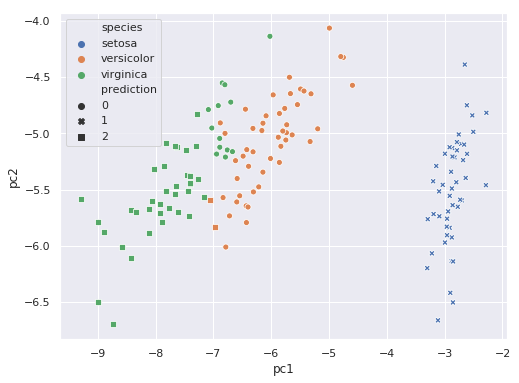

In [20]:
sns.scatterplot(data=kMeansDf, x='pc1', y='pc2', hue='species', style='prediction');